# Aplicando Redes Neuronales Recurrentes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras import backend as K


def rmse(y_true, y_pred):
    """
    Calcula el error cuadrático medio (RMSE) entre las predicciones y los valores verdaderos.

    Args:
        y_true (tensor): Valores verdaderos.
        y_pred (tensor): Valores predichos.

    Returns:
        tensor: RMSE.
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def split_dataframe(df, train_ratio=0.7, test_ratio=0.2):
    """
    Divide un DataFrame en conjuntos de entrenamiento, prueba y evaluación.

    Args:
        df (DataFrame): El DataFrame a dividir.
        train_ratio (float, optional): Proporción de datos para entrenamiento. Defaults to 0.7.
        test_ratio (float, optional): Proporción de datos para prueba. Defaults to 0.2.

    Returns:
        tuple: DataFrames de entrenamiento, prueba y evaluación.
    """
    total_size = len(df)  # Tamaño total del DataFrame
    train_size = int(total_size * train_ratio)  # Tamaño del conjunto de entrenamiento
    test_size = int(total_size * test_ratio)  # Tamaño del conjunto de prueba
    eval_size = total_size - train_size - test_size  # Tamaño del conjunto de evaluación

    df_train = df.iloc[:train_size]  # Conjunto de entrenamiento
    df_test = df.iloc[train_size:train_size + test_size]  # Conjunto de prueba
    df_eval = df.iloc[train_size + test_size:]  # Conjunto de evaluación

    return df_train, df_test, df_eval


def scale_datasets(train_df, test_df, eval_df):
    """
    Escala los conjuntos de datos de entrenamiento, prueba y evaluación.

    Args:
        train_df (DataFrame): DataFrame de entrenamiento.
        test_df (DataFrame): DataFrame de prueba.
        eval_df (DataFrame): DataFrame de evaluación.

    Returns:
        tuple: DataFrames escalados de entrenamiento, prueba y evaluación, y diccionario de escaladores.
    """
    scalers = {}  # Diccionario para almacenar los escaladores
    scaled_train_df = train_df.copy()  # Copia del DataFrame de entrenamiento
    scaled_test_df = test_df.copy()  # Copia del DataFrame de prueba
    scaled_eval_df = eval_df.copy()  # Copia del DataFrame de evaluación

    for column in train_df.columns:
        scaler = MinMaxScaler()  # Crear un escalador MinMax para cada columna
        scaled_train_df[column] = scaler.fit_transform(train_df[[column]])  # Ajustar y transformar los datos de entrenamiento
        scaled_test_df[column] = scaler.transform(test_df[[column]])  # Transformar los datos de prueba
        scaled_eval_df[column] = scaler.transform(eval_df[[column]])  # Transformar los datos de evaluación
        scalers[column] = scaler  # Guardar el escalador para cada columna

    return scaled_train_df, scaled_test_df, scaled_eval_df, scalers

def create_sequences(data, input_columns, output_columns, time_steps, future_steps=1):
    """
    Crea secuencias de datos para modelado de series temporales.

    Args:
        data (DataFrame): DataFrame con los datos.
        input_columns (list): Columnas de entrada.
        output_columns (list): Columnas de salida.
        time_steps (int): Número de pasos de tiempo para las secuencias de entrada.
        future_steps (int, optional): Número de pasos de tiempo futuros para las secuencias de salida. Defaults to 1.

    Returns:
        tuple: Arrays de entrada y salida para el modelo.
    """
    X, y = [], []  # Listas para almacenar las secuencias de entrada y salida
    data_array = data.values  # Convertir el DataFrame a un array numpy

    input_indices = data.columns.get_indexer(input_columns)  # Índices de las columnas de entrada
    output_indices = data.columns.get_indexer(output_columns)  # Índices de las columnas de salida

    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data_array[i:i + time_steps, input_indices])  # Crear secuencia de entrada
        y.append(data_array[i + time_steps:i + time_steps + future_steps, output_indices].flatten())  # Crear secuencia de salida

    return np.array(X), np.array(y)

def create_simple_rnn_model(input_shape, output_size, future_steps, rnn_units=50, hidden_units=50, output_activation='linear'):
    """
    Crea un modelo SimpleRNN.

    Args:
        input_shape (tuple): Forma de las secuencias de entrada.
        output_size (int): Tamaño de la salida.
        future_steps (int): Número de pasos de tiempo futuros.
        rnn_units (int, optional): Unidades de la capa RNN. Defaults to 50.
        hidden_units (int, optional): Unidades de la capa oculta. Defaults to 50.
        output_activation (str, optional): Activación de la capa de salida. Defaults to 'linear'.

    Returns:
        model: Modelo compilado de SimpleRNN.
    """
    model = Sequential()  # Crear un modelo secuencial
    model.add(SimpleRNN(rnn_units, input_shape=input_shape, return_sequences=False))  # Añadir capa SimpleRNN
    model.add(Dense(hidden_units, activation='relu'))  # Añadir capa oculta densa
    model.add(Dense(output_size * future_steps, activation=output_activation))  # Añadir capa de salida
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])  # Compilar el modelo
    return model

def create_lstm_model(input_shape, output_size, future_steps, lstm_units=50, hidden_units=50, output_activation='linear'):
    """
    Crea un modelo LSTM.

    Args:
        input_shape (tuple): Forma de las secuencias de entrada.
        output_size (int): Tamaño de la salida.
        future_steps (int): Número de pasos de tiempo futuros.
        lstm_units (int, optional): Unidades de la capa LSTM. Defaults to 50.
        hidden_units (int, optional): Unidades de la capa oculta. Defaults to 50.
        output_activation (str, optional): Activación de la capa de salida. Defaults to 'linear'.

    Returns:
        model: Modelo compilado de LSTM.
    """
    model = Sequential()  # Crear un modelo secuencial
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=False))  # Añadir capa LSTM
    model.add(Dense(hidden_units, activation='relu'))  # Añadir capa oculta densa
    model.add(Dense(output_size * future_steps, activation=output_activation))  # Añadir capa de salida
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])  # Compilar el modelo
    return model


def create_gru_model(input_shape, output_size, future_steps, gru_units=50, hidden_units=50, output_activation='linear'):
    """
    Crea un modelo GRU.

    Args:
        input_shape (tuple): Forma de las secuencias de entrada.
        output_size (int): Tamaño de la salida.
        future_steps (int): Número de pasos de tiempo futuros.
        gru_units (int, optional): Unidades de la capa GRU. Defaults to 50.
        hidden_units (int, optional): Unidades de la capa oculta. Defaults to 50.
        output_activation (str, optional): Activación de la capa de salida. Defaults to 'linear'.

    Returns:
        model: Modelo compilado de GRU.
    """
    model = Sequential()  # Crear un modelo secuencial
    model.add(GRU(gru_units, input_shape=input_shape, return_sequences=False))  # Añadir capa GRU
    model.add(Dense(hidden_units, activation='relu'))  # Añadir capa oculta densa
    model.add(Dense(output_size * future_steps, activation=output_activation))  # Añadir capa de salida
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])  # Compilar el modelo
    return model

def plot_final_prediction(model, X, y, scalers, output_columns, future_steps, title):
    """
    Grafica las predicciones finales del modelo en comparación con los valores reales.

    Args:
        model (Sequential): Modelo entrenado.
        X (ndarray): Datos de entrada.
        y (ndarray): Valores reales.
        scalers (dict): Diccionario de escaladores para reescalar los datos.
        output_columns (list): Columnas de salida.
        future_steps (int): Número de pasos de tiempo futuros.
        title (str): Título de la gráfica.
    """
    predictions = model.predict(X).reshape(-1, future_steps, len(output_columns))  # Realizar predicciones y darles forma

    # Reescalar las predicciones y los valores reales
    y_rescaled = np.zeros((y.shape[0], len(output_columns)))
    predictions_rescaled = np.zeros((predictions.shape[0], future_steps, len(output_columns)))

    for i, column in enumerate(output_columns):
        y_rescaled[:, i] = scalers[column].inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1)  # Reescalar valores reales
        for step in range(future_steps):
            predictions_rescaled[:, step, i] = scalers[column].inverse_transform(predictions[:, step, i].reshape(-1, 1)).reshape(-1)  # Reescalar predicciones

    plt.figure(figsize=(14, 5))  # Crear figura
    for i in range(len(output_columns)):
        plt.plot(y_rescaled[:, i], label='Valor Real')  # Graficar valores reales
        plt.plot(predictions_rescaled[:, -1, i], label='Predicción')  # Graficar predicciones
        plt.title(f'{title} - Variable {output_columns[i]}')  # Añadir título
        plt.legend()

    plt.tight_layout()
    plt.show()

# Función para graficar los errores finales del modelo
def plot_final_errors(model, X, y, scalers, output_columns, future_steps, title):
    """
    Grafica los errores finales del modelo en comparación con los valores reales.

    Args:
        model (Sequential): Modelo entrenado.
        X (ndarray): Datos de entrada.
        y (ndarray): Valores reales.
        scalers (dict): Diccionario de escaladores para reescalar los datos.
        output_columns (list): Columnas de salida.
        future_steps (int): Número de pasos de tiempo futuros.
        title (str): Título de la gráfica.
    """
    predictions = model.predict(X).reshape(-1, future_steps, len(output_columns))  # Realizar predicciones y darles forma

    # Reescalar las predicciones y los valores reales
    y_rescaled = np.zeros((y.shape[0], len(output_columns)))
    predictions_rescaled = np.zeros((predictions.shape[0], future_steps, len(output_columns)))

    for i, column in enumerate(output_columns):
        y_rescaled[:, i] = scalers[column].inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1)  # Reescalar valores reales
        for step in range(future_steps):
            predictions_rescaled[:, step, i] = scalers[column].inverse_transform(predictions[:, step, i].reshape(-1, 1)).reshape(-1)  # Reescalar predicciones

    errors_rescaled = y_rescaled - predictions_rescaled[:, -1, :]  # Calcular errores reescalados

    plt.figure(figsize=(14, 5))  # Crear figura
    for i in range(len(output_columns)):
        plt.plot(errors_rescaled[:, i], label='Error')  # Graficar errores
        plt.title(f'{title} - Error Variable {output_columns[i]}')  # Añadir título
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_training_history(history, title='Historial de Entrenamiento'):
    """
    Grafica el historial de entrenamiento del modelo.

    Args:
        history (History): Historial de entrenamiento del modelo.
        title (str, optional): Título de la gráfica. Defaults to 'Historial de Entrenamiento'.
    """
    # Extraer la información del historial
    history_dict = history.history

    # Crear una figura
    plt.figure(figsize=(14, 5))

    # Graficar la pérdida (loss)
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Pérdida en Entrenamiento')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Pérdida en Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el Entrenamiento')
    plt.legend()

    # Graficar la métrica RMSE
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['rmse'], label='RMSE en Entrenamiento')
    if 'val_rmse' in history_dict:
        plt.plot(history_dict['val_rmse'], label='RMSE en Validación')
    plt.xlabel('Épocas')
    plt.ylabel('RMSE')
    plt.title('RMSE durante el Entrenamiento')
    plt.legend()

    # Ajustar el diseño y mostrar la gráfica
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [2]:
# Paso 1: Leer el archivo CSV
file_path = 'Datos_procesados.csv'  # Reemplaza con la ruta a tu archivo
df = pd.read_csv(file_path)

df_train, df_test, df_eval = split_dataframe(df, train_ratio=0.7, test_ratio=0.2)

print(f"Tamaño de datos de entrenamiento: {len(df_train)}")
print(f"Tamaño de datos de prueba: {len(df_test)}")
print(f"Tamaño de datos de evaluación: {len(df_eval)}")


Tamaño de datos de entrenamiento: 2149
Tamaño de datos de prueba: 614
Tamaño de datos de evaluación: 308


In [3]:
scaled_train_df, scaled_test_df, scaled_eval_df, scalers = scale_datasets(df_train, df_test, df_eval)

In [4]:
scaled_train_df

,CO,NO,NO2,NOX,O3,PM10,PM25,SO2
0,0.584911,0.586398,0.356373,0.470833,0.172049,0.246532,0.219287,0.101512
1,0.682430,0.669829,0.361681,0.564959,0.211348,0.385056,0.322870,0.148350
2,0.460512,0.293649,0.407132,0.340105,0.150381,0.280042,0.276119,0.967331
3,0.707337,0.611073,0.478761,0.624433,0.116930,0.389721,0.435754,0.427140
4,0.361435,0.289474,0.256701,0.266717,0.205506,0.256709,0.161795,0.196618
...,...,...,...,...,...,...,...,...
2144,0.040115,0.079735,0.580195,0.068810,0.383999,0.233119,0.101721,0.020623
2145,0.101566,0.095842,0.154968,0.120647,0.269731,0.147121,0.053030,0.011945
2146,0.144927,0.128927,0.285428,0.198576,0.278440,0.107948,0.074678,0.056440
2147,0.219412,0.300732,0.407002,0.352302,0.330122,0.250423,0.210987,0.290732


In [5]:
time_steps = 48
future_steps = 12
#input_columns = ['CE-CO','CE-PM10','julian_day','hour']  # Nombres de las columnas de entrada en el DataFrame escalado
input_columns = ['CO']  # Nombres de las columnas de entrada en el DataFrame escalado
output_columns = ['CO']  # Nombres de las columnas de salida en el DataFrame escalado

In [6]:

X_train, y_train = create_sequences(scaled_train_df, input_columns, output_columns, time_steps, future_steps)
X_test, y_test = create_sequences(scaled_test_df, input_columns, output_columns, time_steps, future_steps)
X_eval, y_eval = create_sequences(scaled_eval_df, input_columns, output_columns, time_steps, future_steps)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_test: {y_test.shape}")
print(f"Tamaño de X_eval: {X_eval.shape}")
print(f"Tamaño de y_eval: {y_eval.shape}")

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = len(output_columns)


Tamaño de X_train: (2090, 48, 1)
Tamaño de y_train: (2090, 12)
Tamaño de X_test: (555, 48, 1)
Tamaño de y_test: (555, 12)
Tamaño de X_eval: (249, 48, 1)
Tamaño de y_eval: (249, 12)


In [9]:
time_steps = 48
future_steps = 12
input_columns = ['CO','NO','NO2','NOX	']  # Nombres de las columnas de entrada en el DataFrame escalado
#input_columns = ['CO']  # Nombres de las columnas de entrada en el DataFrame escalado
output_columns = ['CO']  # Nombres de las columnas de salida en el DataFrame escalado

Epoch 1/50
17/17 [==============================] - 4s 93ms/step - loss: 0.1534 - rmse: 0.3708 - val_loss: 0.0327 - val_rmse: 0.1774
Epoch 2/50
17/17 [==============================] - 2s 87ms/step - loss: 0.0372 - rmse: 0.1910 - val_loss: 0.0189 - val_rmse: 0.1311
Epoch 3/50
17/17 [==============================] - 1s 77ms/step - loss: 0.0235 - rmse: 0.1530 - val_loss: 0.0156 - val_rmse: 0.1178
Epoch 4/50
17/17 [==============================] - 1s 34ms/step - loss: 0.0213 - rmse: 0.1457 - val_loss: 0.0148 - val_rmse: 0.1145
Epoch 5/50
17/17 [==============================] - 1s 33ms/step - loss: 0.0211 - rmse: 0.1452 - val_loss: 0.0147 - val_rmse: 0.1146
Epoch 6/50
17/17 [==============================] - 1s 33ms/step - loss: 0.0211 - rmse: 0.1449 - val_loss: 0.0141 - val_rmse: 0.1114
Epoch 7/50
17/17 [==============================] - 1s 34ms/step - loss: 0.0208 - rmse: 0.1440 - val_loss: 0.0138 - val_rmse: 0.1097
Epoch 8/50
17/17 [==============================] - 1s 33ms/step - lo

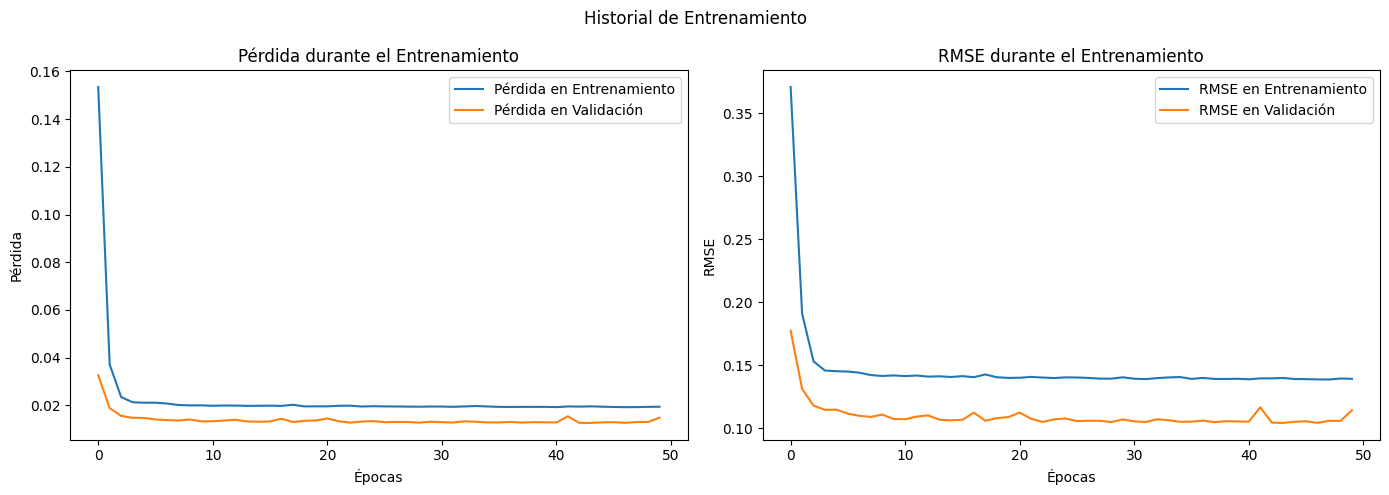

In [10]:
# Crear y entrenar el modelo SimpleRNN MULTI
model_simple_rnn = create_simple_rnn_model(input_shape, output_size, future_steps)
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), shuffle=True)
plot_training_history(history_simple_rnn)

Epoch 1/50
17/17 [==============================] - 4s 46ms/step - loss: 0.1453 - rmse: 0.3669 - val_loss: 0.0248 - val_rmse: 0.1513
Epoch 2/50
17/17 [==============================] - 1s 31ms/step - loss: 0.0383 - rmse: 0.1936 - val_loss: 0.0186 - val_rmse: 0.1329
Epoch 3/50
17/17 [==============================] - 1s 30ms/step - loss: 0.0234 - rmse: 0.1532 - val_loss: 0.0157 - val_rmse: 0.1181
Epoch 4/50
17/17 [==============================] - 1s 49ms/step - loss: 0.0214 - rmse: 0.1455 - val_loss: 0.0143 - val_rmse: 0.1127
Epoch 5/50
17/17 [==============================] - 1s 54ms/step - loss: 0.0207 - rmse: 0.1433 - val_loss: 0.0143 - val_rmse: 0.1118
Epoch 6/50
17/17 [==============================] - 1s 54ms/step - loss: 0.0204 - rmse: 0.1426 - val_loss: 0.0137 - val_rmse: 0.1093
Epoch 7/50
17/17 [==============================] - 1s 41ms/step - loss: 0.0200 - rmse: 0.1415 - val_loss: 0.0136 - val_rmse: 0.1087
Epoch 8/50
17/17 [==============================] - 1s 33ms/step - lo

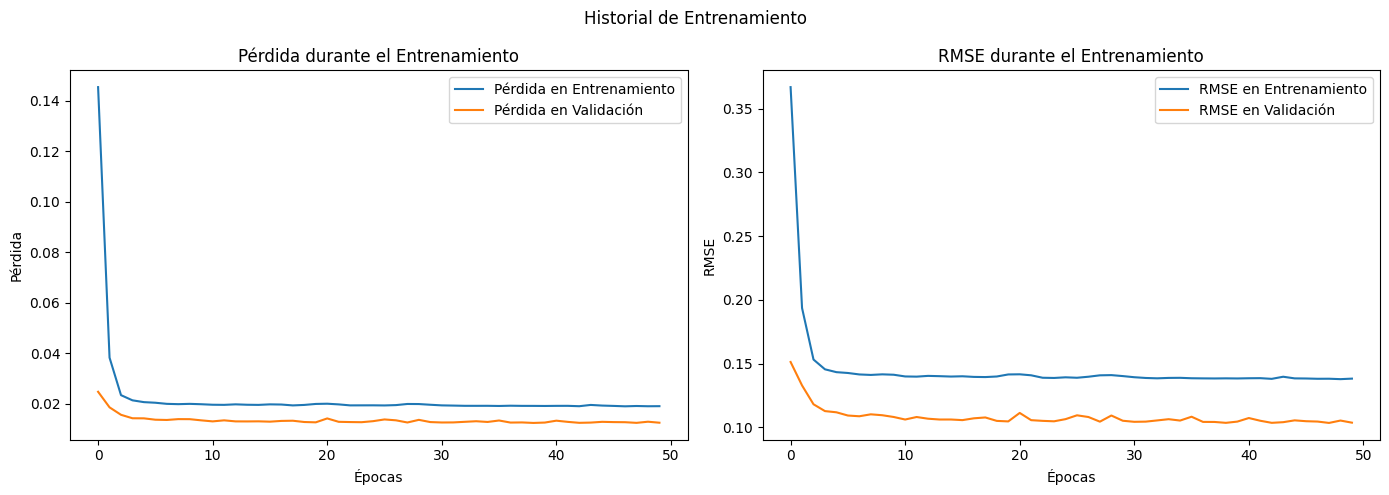

In [7]:
# Crear y entrenar el modelo SimpleRNN
model_simple_rnn = create_simple_rnn_model(input_shape, output_size, future_steps)
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), shuffle=True)
plot_training_history(history_simple_rnn)

In [8]:
model_simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 12)                612       
                                                                 
Total params: 5762 (22.51 KB)
Trainable params: 5762 (22.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
160/160 [==============================] - 4s 12ms/step - loss: 0.0091 - rmse: 0.0895 - val_loss: 0.0030 - val_rmse: 0.0522
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.0056 - rmse: 0.0742 - val_loss: 0.0028 - val_rmse: 0.0512
Epoch 3/50
160/160 [==============================] - 1s 6ms/step - loss: 0.0044 - rmse: 0.0657 - val_loss: 0.0022 - val_rmse: 0.0445
Epoch 4/50
160/160 [==============================] - 1s 6ms/step - loss: 0.0035 - rmse: 0.0591 - val_loss: 0.0025 - val_rmse: 0.0482
Epoch 5/50
160/160 [==============================] - 1s 6ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0020 - val_rmse: 0.0422
Epoch 6/50
160/160 [==============================] - 1s 6ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0020 - val_rmse: 0.0434
Epoch 7/50
160/160 [==============================] - 1s 6ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0019 - val_rmse: 0.0421
Epoch 8/50
160/160 [==============================] - 1s 6ms/

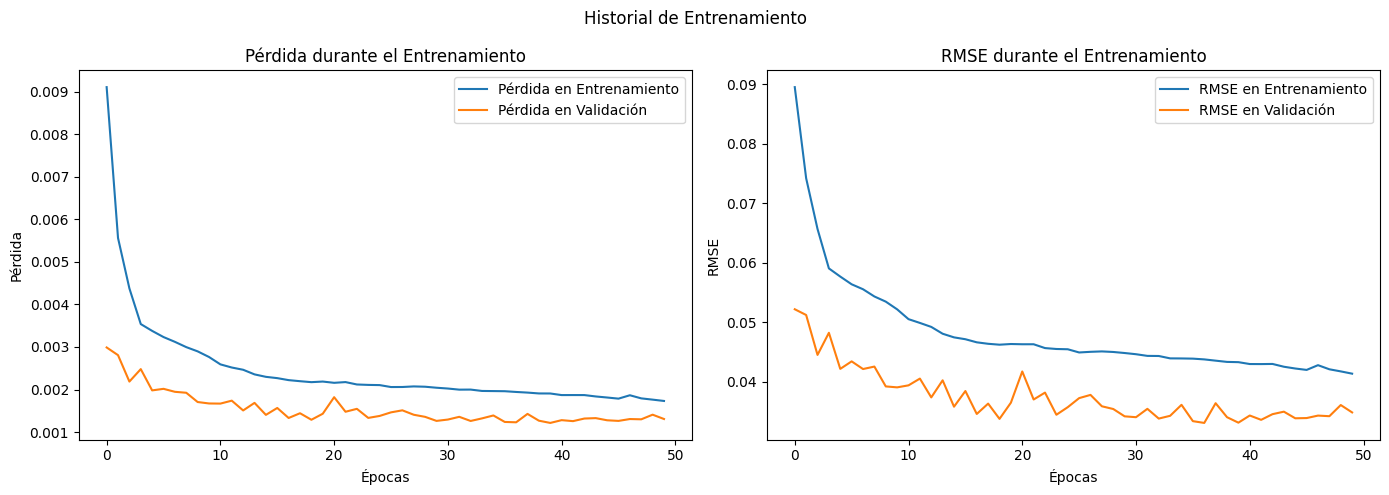

In [ ]:
# Crear y entrenar el modelo LSTM
model_lstm = create_lstm_model(input_shape, output_size, future_steps)
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), shuffle=True)
plot_training_history(history_lstm)